===== Single-run UCB with live updates =====
[UCB] Step  1000 | Avg Reward: 1.189 | % Optimal: 84.80
[UCB] Step  2000 | Avg Reward: 1.229 | % Optimal: 91.15
[UCB] Step  3000 | Avg Reward: 1.239 | % Optimal: 93.60
[UCB] Step  4000 | Avg Reward: 1.257 | % Optimal: 95.12
[UCB] Step  5000 | Avg Reward: 1.262 | % Optimal: 95.92
[UCB] Step  6000 | Avg Reward: 1.270 | % Optimal: 96.57
[UCB] Step  7000 | Avg Reward: 1.275 | % Optimal: 97.04
[UCB] Step  8000 | Avg Reward: 1.273 | % Optimal: 97.39
[UCB] Step  9000 | Avg Reward: 1.272 | % Optimal: 97.61
[UCB] Step 10000 | Avg Reward: 1.279 | % Optimal: 97.85

UCB Progress Table (every 1000 steps):


,Steps,Avg Reward,% Optimal Action
0,1000,1.188883,84.800000
1,2000,1.228798,91.150000
2,3000,1.239386,93.600000
3,4000,1.256523,95.125000
4,5000,1.261590,95.920000
5,6000,1.270360,96.566667
6,7000,1.275242,97.042857
7,8000,1.273274,97.387500
8,9000,1.272242,97.611111
9,10000,1.279496,97.850000



===== Single-run ε-greedy with live updates (ε=0.1) =====
[ε-greedy ε=0.1] Step  1000 | Avg Reward: 1.148 | % Optimal: 89.50
[ε-greedy ε=0.1] Step  2000 | Avg Reward: 1.153 | % Optimal: 89.95
[ε-greedy ε=0.1] Step  3000 | Avg Reward: 1.159 | % Optimal: 89.87
[ε-greedy ε=0.1] Step  4000 | Avg Reward: 1.161 | % Optimal: 90.40
[ε-greedy ε=0.1] Step  5000 | Avg Reward: 1.165 | % Optimal: 90.64
[ε-greedy ε=0.1] Step  6000 | Avg Reward: 1.164 | % Optimal: 90.83
[ε-greedy ε=0.1] Step  7000 | Avg Reward: 1.162 | % Optimal: 90.80
[ε-greedy ε=0.1] Step  8000 | Avg Reward: 1.172 | % Optimal: 90.83
[ε-greedy ε=0.1] Step  9000 | Avg Reward: 1.175 | % Optimal: 91.00
[ε-greedy ε=0.1] Step 10000 | Avg Reward: 1.171 | % Optimal: 91.15

ε-greedy Progress Table (every 1000 steps):


,Steps,Avg Reward,% Optimal Action
0,1000,1.147965,89.500000
1,2000,1.152628,89.950000
2,3000,1.159342,89.866667
3,4000,1.160947,90.400000
4,5000,1.164952,90.640000
5,6000,1.164083,90.833333
6,7000,1.162089,90.800000
7,8000,1.172441,90.825000
8,9000,1.174848,91.000000
9,10000,1.171009,91.150000


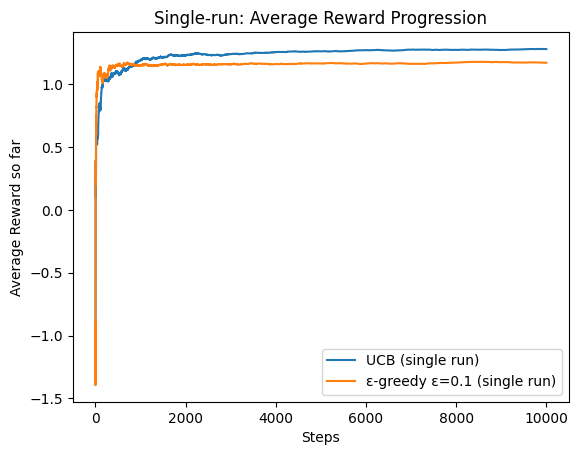

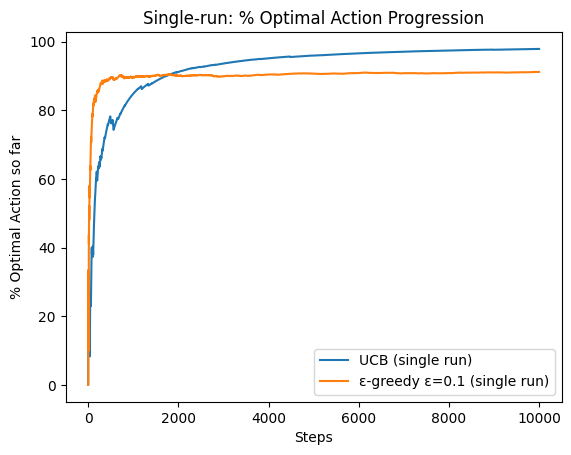

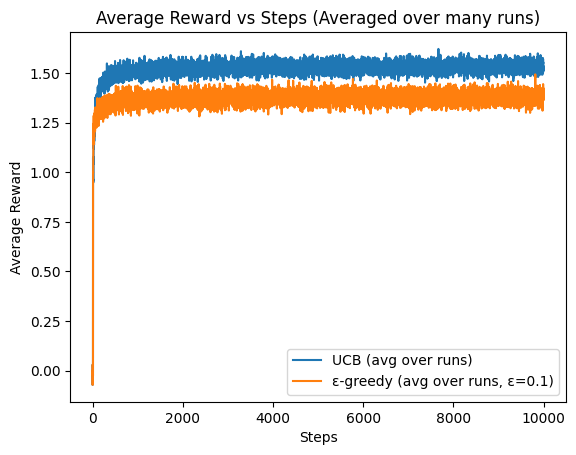

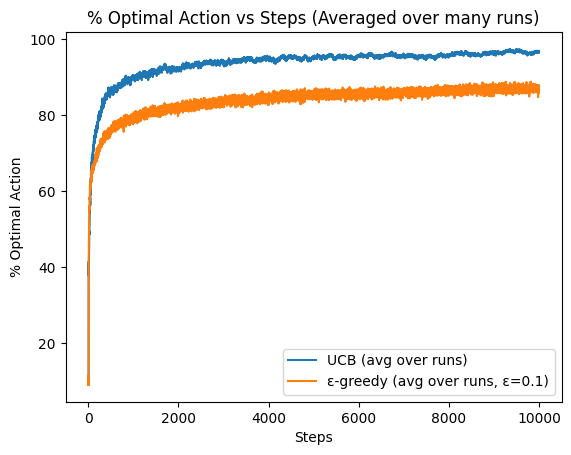

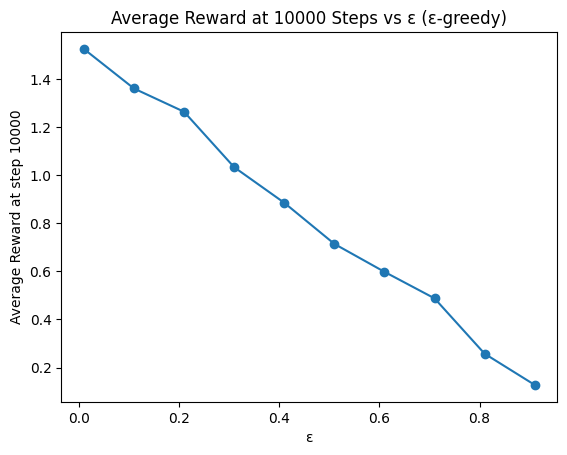

Best ε in sweep: 0.01 | Avg reward at 10,000: 1.526217409242311


In [1]:
# Google Colab: Multi-Armed Bandit (UCB vs ε-greedy) + Progress table + Live updates
# - Initialization: pull each arm once
# - Loop: 10,000 steps
# - UCB score: Q(a) + sqrt( (2 ln t) / N(a) )
# - Tracks: avg reward, % optimal action
# - Shows: progress table every 1000 steps + live prints
# - Plots: (1) avg reward over time, (2) % optimal over time, (3) avg reward at 10k vs ε

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Environment (k-armed bandit)
# -----------------------------
class KArmedBandit:
    def __init__(self, k=10, reward_std=1.0, seed=None):
        self.k = k
        self.reward_std = reward_std
        self.rng = np.random.default_rng(seed)

        # True action values (means)
        self.q_star = self.rng.normal(loc=0.0, scale=1.0, size=k)
        self.optimal_action = int(np.argmax(self.q_star))

    def step(self, action: int) -> float:
        # Stochastic reward: Normal(q*(a), 1)
        return float(self.rng.normal(loc=self.q_star[action], scale=self.reward_std))


# -----------------------------
# Progress table helper
# -----------------------------
def progress_table(rewards, optimal, every=1000):
    rows = []
    for t in range(every, len(rewards) + 1, every):
        rows.append([
            t,
            float(np.mean(rewards[:t])),
            float(np.mean(optimal[:t]) * 100.0)
        ])
    return pd.DataFrame(rows, columns=["Steps", "Avg Reward", "% Optimal Action"])


# -----------------------------
# Algorithms
# -----------------------------
def run_ucb(env: KArmedBandit, steps=10_000, live_every=1000):
    k = env.k
    Q = np.zeros(k)                 # sample averages
    N = np.zeros(k, dtype=int)      # counts

    rewards = np.zeros(steps)
    optimal = np.zeros(steps)

    # Initialization: pull each arm once
    t = 0
    for a in range(k):
        r = env.step(a)
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]
        rewards[t] = r
        optimal[t] = 1 if a == env.optimal_action else 0
        t += 1
        if t >= steps:
            return rewards, optimal, Q, N

    # Main loop
    for t in range(t, steps):
        # UCB score: Q(a) + sqrt( (2 ln (t+1)) / N(a) )
        ucb = Q + np.sqrt((2.0 * np.log(t + 1.0)) / N)
        a = int(np.argmax(ucb))

        r = env.step(a)
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]

        rewards[t] = r
        optimal[t] = 1 if a == env.optimal_action else 0

        # Live updates
        if live_every and ((t + 1) % live_every == 0):
            avg_r = float(np.mean(rewards[:t+1]))
            opt_pct = float(np.mean(optimal[:t+1]) * 100.0)
            print(f"[UCB] Step {t+1:5d} | Avg Reward: {avg_r:.3f} | % Optimal: {opt_pct:.2f}")

    return rewards, optimal, Q, N


def run_eps_greedy(env: KArmedBandit, eps=0.1, steps=10_000, live_every=1000):
    k = env.k
    Q = np.zeros(k)
    N = np.zeros(k, dtype=int)

    rewards = np.zeros(steps)
    optimal = np.zeros(steps)

    # Initialization: pull each arm once
    t = 0
    for a in range(k):
        r = env.step(a)
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]
        rewards[t] = r
        optimal[t] = 1 if a == env.optimal_action else 0
        t += 1
        if t >= steps:
            return rewards, optimal, Q, N

    rng = env.rng
    for t in range(t, steps):
        if rng.random() < eps:
            a = int(rng.integers(0, k))
        else:
            a = int(np.argmax(Q))

        r = env.step(a)
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]

        rewards[t] = r
        optimal[t] = 1 if a == env.optimal_action else 0

        # Live updates
        if live_every and ((t + 1) % live_every == 0):
            avg_r = float(np.mean(rewards[:t+1]))
            opt_pct = float(np.mean(optimal[:t+1]) * 100.0)
            print(f"[ε-greedy ε={eps}] Step {t+1:5d} | Avg Reward: {avg_r:.3f} | % Optimal: {opt_pct:.2f}")

    return rewards, optimal, Q, N


# -----------------------------
# Multi-run simulation (averages)
# -----------------------------
def simulate(algorithm="ucb", eps=0.1, runs=2000, steps=10_000, k=10, seed=0):
    avg_reward = np.zeros(steps)
    pct_optimal = np.zeros(steps)

    base_rng = np.random.default_rng(seed)

    for i in range(runs):
        env = KArmedBandit(k=k, seed=int(base_rng.integers(0, 1_000_000_000)))

        if algorithm == "ucb":
            r, opt, _, _ = run_ucb(env, steps=steps, live_every=0)     # no spam in multi-run
        elif algorithm == "eps":
            r, opt, _, _ = run_eps_greedy(env, eps=eps, steps=steps, live_every=0)
        else:
            raise ValueError("algorithm must be 'ucb' or 'eps'")

        avg_reward += r
        pct_optimal += opt

    avg_reward /= runs
    pct_optimal = (pct_optimal / runs) * 100.0
    return avg_reward, pct_optimal


# ============================================================
# PART A: Single-run demo with LIVE updates + progress table
# ============================================================
steps = 10_000
k = 10

print("===== Single-run UCB with live updates =====")
env1 = KArmedBandit(k=k, seed=123)
rewards_ucb, optimal_ucb, Q_ucb, N_ucb = run_ucb(env1, steps=steps, live_every=1000)

print("\nUCB Progress Table (every 1000 steps):")
display(progress_table(rewards_ucb, optimal_ucb, every=1000))

print("\n===== Single-run ε-greedy with live updates (ε=0.1) =====")
env2 = KArmedBandit(k=k, seed=123)
rewards_eps, optimal_eps, Q_eps, N_eps = run_eps_greedy(env2, eps=0.1, steps=steps, live_every=1000)

print("\nε-greedy Progress Table (every 1000 steps):")
display(progress_table(rewards_eps, optimal_eps, every=1000))


# Plot: Average reward over time (single run)
plt.figure()
plt.plot(np.cumsum(rewards_ucb) / np.arange(1, steps+1), label="UCB (single run)")
plt.plot(np.cumsum(rewards_eps) / np.arange(1, steps+1), label="ε-greedy ε=0.1 (single run)")
plt.xlabel("Steps")
plt.ylabel("Average Reward so far")
plt.title("Single-run: Average Reward Progression")
plt.legend()
plt.show()

# Plot: % optimal over time (single run)
plt.figure()
plt.plot(np.cumsum(optimal_ucb) / np.arange(1, steps+1) * 100, label="UCB (single run)")
plt.plot(np.cumsum(optimal_eps) / np.arange(1, steps+1) * 100, label="ε-greedy ε=0.1 (single run)")
plt.xlabel("Steps")
plt.ylabel("% Optimal Action so far")
plt.title("Single-run: % Optimal Action Progression")
plt.legend()
plt.show()


# ============================================================
# PART B: Multi-run average comparison (clean graphs)
# ============================================================
runs = 2000
eps_fixed = 0.1

avg_r_ucb, opt_ucb = simulate("ucb", runs=runs, steps=steps, k=k, seed=1)
avg_r_eps, opt_eps = simulate("eps", eps=eps_fixed, runs=runs, steps=steps, k=k, seed=1)

plt.figure()
plt.plot(avg_r_ucb, label="UCB (avg over runs)")
plt.plot(avg_r_eps, label=f"ε-greedy (avg over runs, ε={eps_fixed})")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward vs Steps (Averaged over many runs)")
plt.legend()
plt.show()

plt.figure()
plt.plot(opt_ucb, label="UCB (avg over runs)")
plt.plot(opt_eps, label=f"ε-greedy (avg over runs, ε={eps_fixed})")
plt.xlabel("Steps")
plt.ylabel("% Optimal Action")
plt.title("% Optimal Action vs Steps (Averaged over many runs)")
plt.legend()
plt.show()


# ============================================================
# PART C: Avg reward at 10,000 steps vs ε (ε from 0.01 to 0.99 step 0.1)
# ============================================================
eps_values = np.arange(0.01, 1.0, 0.1)  # 0.01, 0.11, ..., 0.91
final_avg_rewards = []

for e in eps_values:
    avg_r, _ = simulate("eps", eps=float(e), runs=runs, steps=steps, k=k, seed=2)
    final_avg_rewards.append(float(avg_r[-1]))

plt.figure()
plt.plot(eps_values, final_avg_rewards, marker="o")
plt.xlabel("ε")
plt.ylabel(f"Average Reward at step {steps}")
plt.title(f"Average Reward at {steps} Steps vs ε (ε-greedy)")
plt.show()

best_idx = int(np.argmax(final_avg_rewards))
print("Best ε in sweep:", float(eps_values[best_idx]),
      "| Avg reward at 10,000:", float(final_avg_rewards[best_idx]))